In [39]:
"""

Date: 12 Feb 2020

Python version:      3.7
Tensorboard version: 1.14.0
PyTorch version:     1.2.0

@author: Maksim Lavrov

CIFAR10

Only single flexilayer
No max pooling following

"""

# imports
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# datasets
trainset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.CIFAR10('./data',
    download=True,
    train=False,
    transform=transform)

#create a dataset subset to reduce training time

sampler_train = list(range(0, len(trainset), 5000))
sampler_test = list(range(0, len(testset), 5000))
#trainset_samp = torch.utils.data.Subset(trainset, sampler_train)
#testset_samp = torch.utils.data.Subset(testset, sampler_test)

#set size of batch and learning rate
batch_size=4
lr=0.001

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [40]:
class FlexiLayer(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = kernel_size
        stride = stride
        padding = padding
        dilation = dilation
        super(FlexiLayer, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            groups, bias, padding_mode)
        
        
        self.threshold1 = nn.parameter.Parameter(torch.empty(4, 12, 28, 28).normal_(mean=0.5,std=0.1), requires_grad=True)
        self.memorized = self.threshold1.clone()
        self.memorized_1loop = []
        self.memorized_1pixel = []
        self.thresh_max = []
        self.thresh_min = []
        self.thresh_mean = []
            
    def forward(self, t):
        
        t_1 = F.relu(F.conv2d(t, self.weight)) # get convolution result
        t_2 = F.avg_pool2d(t, kernel_size=5, stride=1) # get avg result with the same kernel size
        t_2 = torch.cat((t_2, t_2, t_2, t_2), 1)
        m = nn.Sigmoid()
        condmax = torch.sub(t_2, self.threshold1)
        condconv = torch.sub(t_2, self.threshold1)
        t_2 = m(condmax*50)*t_2 # 
        t_1 = m(condconv*(-50))*t_1 # 
        t = torch.add(t_2, t_1)
        #t = F.max_pool2d(t, kernel_size=2, stride=2)
        
        return t

In [41]:
#Xavier threshold initialization

def init_weights(m):
    if type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform(m.threshold1)
        m.bias.data.fill_(0.01)

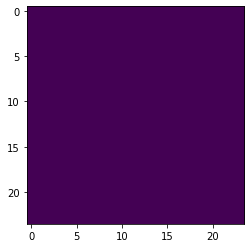

In [42]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.flex1 = FlexiLayer(in_channels=3, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features= 3 * 56 * 56, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10) # number of classes

    def forward(self, t):
        
        # (2) Flexible layer
        t = self.flex1(t)
        
        # (4) hidden linear layer
        t = F.relu(self.fc1(t.reshape(-1, 3 * 56 * 56)))
        # (5) hidden linear layer
        t = F.relu(self.fc2(t))
        # (6) output layer
        t = self.out(t)
        
        return t

net = Net()
memorized = net.flex1.memorized
#before training
imgplot = plt.imshow(net.flex1.threshold1.detach().numpy()[1,1,:] - memorized.detach().numpy()[1,1,:])

Text(0.5, 0, 'Threshold layer values')

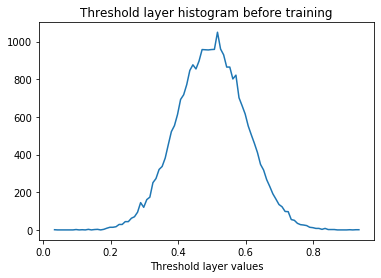

In [43]:
#before training
plt.figure()
thresh_hist = torch.histc(memorized)
start = np.min(memorized.detach().numpy())
end = np.max(memorized.detach().numpy())
xhist = torch.linspace(start,end,100) # histogram x-axis
plt.plot(xhist, thresh_hist.detach().numpy())
plt.title('Threshold layer histogram before training')
plt.xlabel('Count')
plt.xlabel('Threshold layer values')